In [133]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

torch.Size([1, 32, 32])


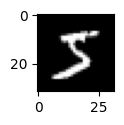

In [134]:
transform = v2.Compose([
    v2.Pad(2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=transform, download=True)

x, y = train_dataset[0]
print(x.shape)
x = x.squeeze(0)
plt.figure(figsize=(1,1))
plt.imshow(x, cmap='grey')
plt.show()

In [135]:
class Ebm(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.activation(out)

        out = self.conv3(out)
        out = self.activation(out)

        out = self.conv4(out)
        out = self.activation(out)

        out = self.conv5(out)
        out = self.activation(out)

        out = self.flatten(out)
        out = self.dense(out)
        out = self.activation(out)

        return out

model = Ebm()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
out = model(sample)
print(out.shape)
print(out)


torch.Size([1, 1, 32, 32])
torch.Size([1, 1])
tensor([[-0.0316]], grad_fn=<SiluBackward0>)


In [136]:
def generate_samples(model, inp_imgs, steps, step_size, noise):
    imgs_per_step = []
    for _ in range(steps):
        # add noise
        with torch.no_grad():
            inp_imgs += torch.randn(inp_imgs.shape, device=inp_imgs.device) * noise # noise : stddev
            inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)
        
        # get energy score
        inp_imgs.requires_grad_(True)
        out_score = -model(inp_imgs)

        # calculate gradiant
        grads = torch.autograd.grad(
            outputs=out_score, 
            inputs=inp_imgs, 
            grad_outputs=torch.ones_like(out_score))[0]
    
        grads = torch.clip(grads, min=-0.03, max=0.03)

        # add gradiant to image
        with torch.no_grad():
            inp_imgs += -step_size * grads
            inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)
        imgs_per_step.append(inp_imgs)

    return inp_imgs, imgs_per_step


In [137]:
# Generating samples from model to train
class Buffer:
    def __init__(self, model, batch_size, device) -> None:
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.device = device
        self.examples = [
            torch.rand([1, 1,32,32], device=device) * 2 - 1 for _ in range(batch_size)
        ]
    
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(self.batch_size, 0.05)
        rand_imgs = (
            torch.rand([n_new, 1, 32,32], requires_grad=True, device=device) * 2 - 1
        )
        choice_d = random.choices(self.examples, k=(self.batch_size - n_new))
        old_imgs = torch.cat(
            choice_d, dim=0
        )
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = inp_imgs.to(device)
        inp_imgs, _ = generate_samples(
            self.model, inp_imgs, steps, step_size, noise
        )
        self.examples = list(torch.split(inp_imgs, 1, dim=0))  + self.examples
        self.examples = self.examples[:8192]
        return inp_imgs

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
buffer = Buffer(model, 16, device)
res = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
print(res.shape)
    

torch.Size([16, 1, 32, 32])


train[0]: 100%|██████████| 469/469 [00:50<00:00,  9.30it/s, loss:-0.00922]


epoch[0] : -0.04321


train[0]: 100%|██████████| 469/469 [00:06<00:00, 69.99it/s]


epoch[0] : test loss - -0.00922


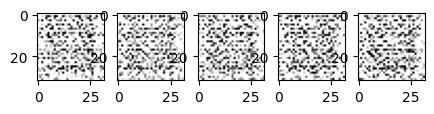

train[1]: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s, loss:-0.11313]


epoch[1] : -0.15534


train[1]: 100%|██████████| 469/469 [00:06<00:00, 68.00it/s]


epoch[1] : test loss - -0.11313


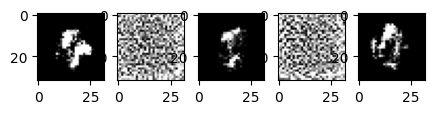

train[2]: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s, loss:-0.37658]


epoch[2] : -0.35440


train[2]: 100%|██████████| 469/469 [00:07<00:00, 66.93it/s]


epoch[2] : test loss - -0.37658


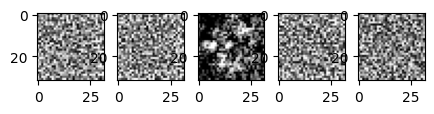

train[3]: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s, loss:-0.87841]


epoch[3] : -0.85752


train[3]: 100%|██████████| 469/469 [00:06<00:00, 69.20it/s]


epoch[3] : test loss - -0.87841


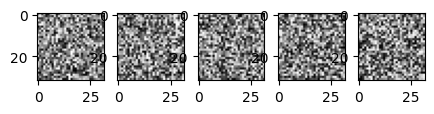

train[4]: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s, loss:-1.33745]


epoch[4] : -1.40567


train[4]: 100%|██████████| 469/469 [00:06<00:00, 68.19it/s]


epoch[4] : test loss - -1.33745


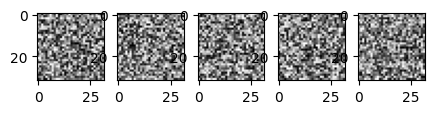

train[5]: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s, loss:-1.37471]


epoch[5] : -1.68263


train[5]: 100%|██████████| 469/469 [00:06<00:00, 69.06it/s]


epoch[5] : test loss - -1.37471


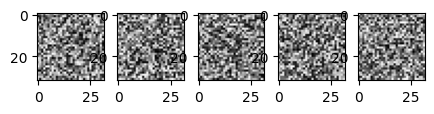

train[6]: 100%|██████████| 469/469 [00:48<00:00,  9.70it/s, loss:-1.62783]


epoch[6] : -1.98856


train[6]: 100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


epoch[6] : test loss - -1.62783


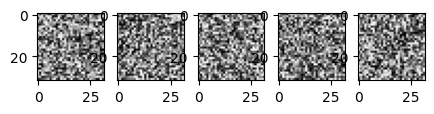

train[7]: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s, loss:-2.25580]


epoch[7] : -2.29059


train[7]: 100%|██████████| 469/469 [00:07<00:00, 66.62it/s]


epoch[7] : test loss - -2.25580


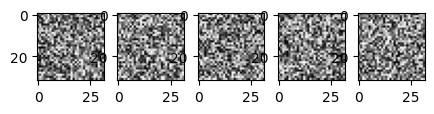

train[8]: 100%|██████████| 469/469 [00:49<00:00,  9.49it/s, loss:-2.10901]


epoch[8] : -2.46138


train[8]: 100%|██████████| 469/469 [00:07<00:00, 66.76it/s]


epoch[8] : test loss - -2.10901


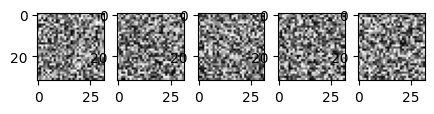

train[9]: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s, loss:-2.23701]


epoch[9] : -2.53659


train[9]: 100%|██████████| 469/469 [00:07<00:00, 66.62it/s]


epoch[9] : test loss - -2.23701


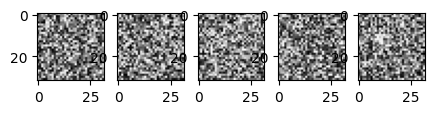

train[10]: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s, loss:-2.36990]


epoch[10] : -2.63078


train[10]: 100%|██████████| 469/469 [00:07<00:00, 66.58it/s]


epoch[10] : test loss - -2.36990


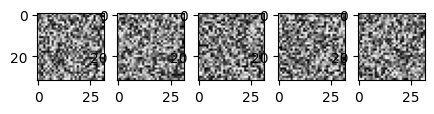

train[11]: 100%|██████████| 469/469 [00:48<00:00,  9.69it/s, loss:-2.30467]


epoch[11] : -2.69100


train[11]: 100%|██████████| 469/469 [00:07<00:00, 66.64it/s]


epoch[11] : test loss - -2.30467


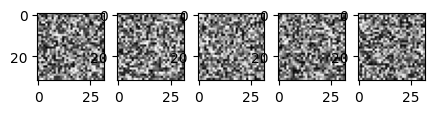

train[12]: 100%|██████████| 469/469 [00:48<00:00,  9.57it/s, loss:-2.36841]


epoch[12] : -2.67900


train[12]: 100%|██████████| 469/469 [00:07<00:00, 66.27it/s]


epoch[12] : test loss - -2.36841


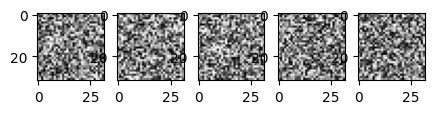

train[13]: 100%|██████████| 469/469 [00:48<00:00,  9.62it/s, loss:-2.37238]


epoch[13] : -2.71042


train[13]: 100%|██████████| 469/469 [00:07<00:00, 66.43it/s]


epoch[13] : test loss - -2.37238


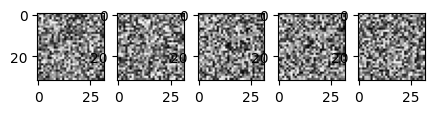

train[14]: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s, loss:-2.37266]


epoch[14] : -2.75470


train[14]: 100%|██████████| 469/469 [00:06<00:00, 67.24it/s]


epoch[14] : test loss - -2.37266


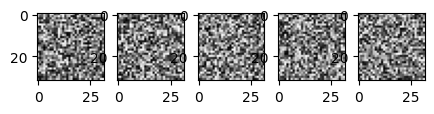

train[15]: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s, loss:-2.37267]


epoch[15] : -2.76639


train[15]: 100%|██████████| 469/469 [00:07<00:00, 66.26it/s]


epoch[15] : test loss - -2.37267


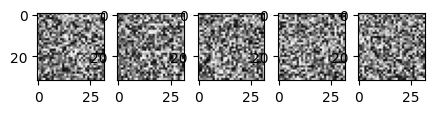

train[16]: 100%|██████████| 469/469 [00:48<00:00,  9.70it/s, loss:-2.23489]


epoch[16] : -2.75116


train[16]: 100%|██████████| 469/469 [00:07<00:00, 65.93it/s]


epoch[16] : test loss - -2.23489


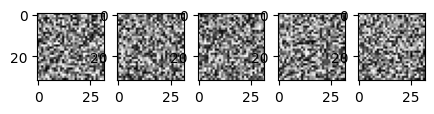

train[17]: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s, loss:-2.37267]


epoch[17] : -2.76510


train[17]: 100%|██████████| 469/469 [00:07<00:00, 66.74it/s]


epoch[17] : test loss - -2.37267


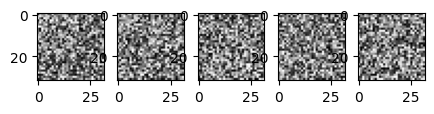

train[18]: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s, loss:-2.37267]


epoch[18] : -2.77006


train[18]: 100%|██████████| 469/469 [00:07<00:00, 65.96it/s]


epoch[18] : test loss - -2.37267


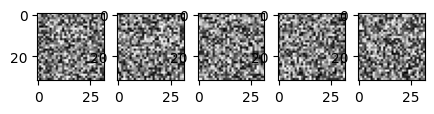

train[19]: 100%|██████████| 469/469 [00:48<00:00,  9.58it/s, loss:-2.37267]


epoch[19] : -2.77007


train[19]: 100%|██████████| 469/469 [00:07<00:00, 66.34it/s]


epoch[19] : test loss - -2.37267


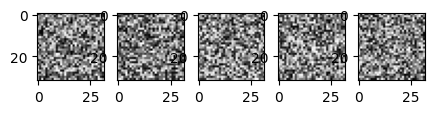

train[20]: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s, loss:-2.37267]


epoch[20] : -2.77007


train[20]: 100%|██████████| 469/469 [00:07<00:00, 66.42it/s]


epoch[20] : test loss - -2.37267


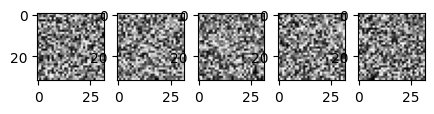

train[21]: 100%|██████████| 469/469 [00:48<00:00,  9.58it/s, loss:-2.37267]


epoch[21] : -2.76657


train[21]: 100%|██████████| 469/469 [00:07<00:00, 66.20it/s]


epoch[21] : test loss - -2.37267


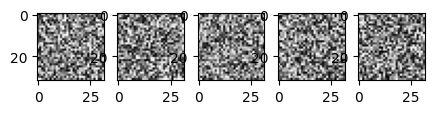

train[22]: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s, loss:-2.37268]


epoch[22] : -2.77007


train[22]: 100%|██████████| 469/469 [00:07<00:00, 65.66it/s]


epoch[22] : test loss - -2.37268


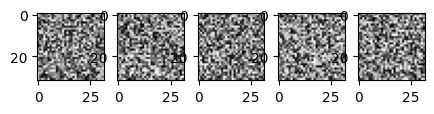

train[23]: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s, loss:-2.37268]


epoch[23] : -2.77007


train[23]: 100%|██████████| 469/469 [00:07<00:00, 66.11it/s]


epoch[23] : test loss - -2.37268


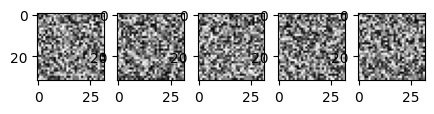

train[24]: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s, loss:-2.37268]


epoch[24] : -2.77007


train[24]: 100%|██████████| 469/469 [00:07<00:00, 66.04it/s]


epoch[24] : test loss - -2.37268


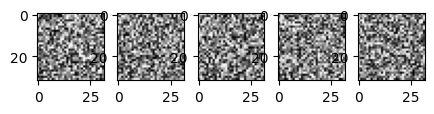

train[25]: 100%|██████████| 469/469 [00:48<00:00,  9.76it/s, loss:-2.37268]


epoch[25] : -2.77007


train[25]: 100%|██████████| 469/469 [00:07<00:00, 66.93it/s]


epoch[25] : test loss - -2.37268


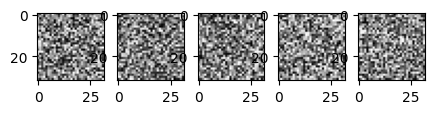

train[26]: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s, loss:-2.37268]


epoch[26] : -2.77007


train[26]: 100%|██████████| 469/469 [00:07<00:00, 66.51it/s]


epoch[26] : test loss - -2.37268


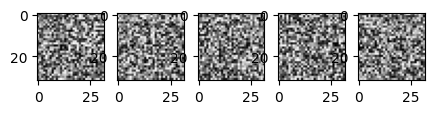

train[27]: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s, loss:-2.37268]


epoch[27] : -2.77007


train[27]: 100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


epoch[27] : test loss - -2.37268


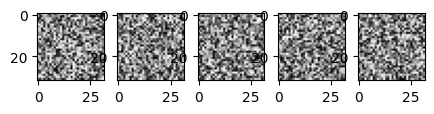

train[28]: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s, loss:-2.37268]


epoch[28] : -2.77007


train[28]: 100%|██████████| 469/469 [00:06<00:00, 67.04it/s]


epoch[28] : test loss - -2.37268


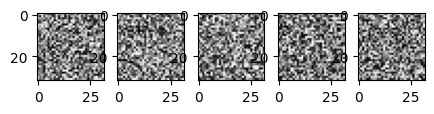

train[29]: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s, loss:-2.37268]


epoch[29] : -2.77007


train[29]: 100%|██████████| 469/469 [00:07<00:00, 66.36it/s]


epoch[29] : test loss - -2.37268


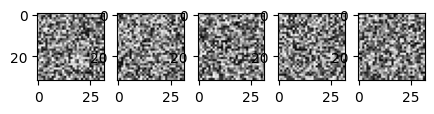

train[30]: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s, loss:-2.37268]


epoch[30] : -2.77007


train[30]: 100%|██████████| 469/469 [00:07<00:00, 66.20it/s]


epoch[30] : test loss - -2.37268


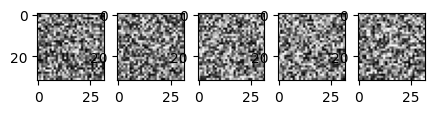

train[31]: 100%|██████████| 469/469 [00:48<00:00,  9.69it/s, loss:-2.37268]


epoch[31] : -2.77007


train[31]: 100%|██████████| 469/469 [00:07<00:00, 65.89it/s]


epoch[31] : test loss - -2.37268


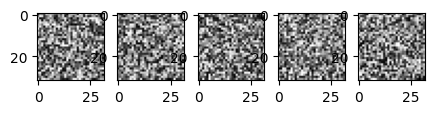

train[32]: 100%|██████████| 469/469 [00:48<00:00,  9.58it/s, loss:-2.37268]


epoch[32] : -2.77007


train[32]: 100%|██████████| 469/469 [00:07<00:00, 65.71it/s]


epoch[32] : test loss - -2.37268


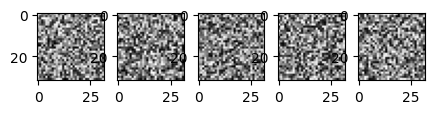

train[33]: 100%|██████████| 469/469 [00:49<00:00,  9.56it/s, loss:-2.37268]


epoch[33] : -2.77007


train[33]: 100%|██████████| 469/469 [00:07<00:00, 66.17it/s]


epoch[33] : test loss - -2.37268


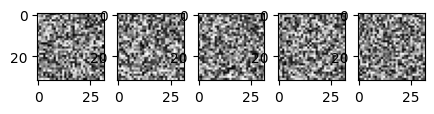

train[34]: 100%|██████████| 469/469 [00:48<00:00,  9.77it/s, loss:-2.37268]


epoch[34] : -2.77007


train[34]: 100%|██████████| 469/469 [00:07<00:00, 66.52it/s]


epoch[34] : test loss - -2.37268


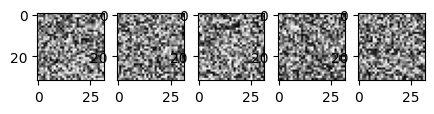

train[35]: 100%|██████████| 469/469 [00:47<00:00,  9.78it/s, loss:-2.37268]


epoch[35] : -2.77007


train[35]: 100%|██████████| 469/469 [00:07<00:00, 65.93it/s]


epoch[35] : test loss - -2.37268


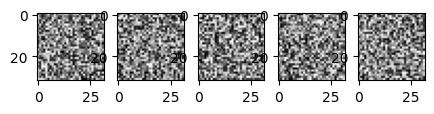

train[36]: 100%|██████████| 469/469 [00:48<00:00,  9.76it/s, loss:-2.37268]


epoch[36] : -2.77007


train[36]: 100%|██████████| 469/469 [00:07<00:00, 66.45it/s]


epoch[36] : test loss - -2.37268


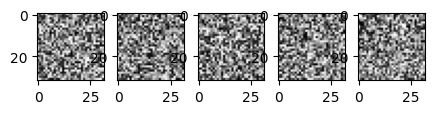

train[37]: 100%|██████████| 469/469 [00:48<00:00,  9.75it/s, loss:-2.37268]


epoch[37] : -2.77007


train[37]: 100%|██████████| 469/469 [00:07<00:00, 66.25it/s]


epoch[37] : test loss - -2.37268


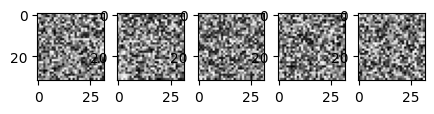

train[38]: 100%|██████████| 469/469 [00:47<00:00,  9.79it/s, loss:-2.37268]


epoch[38] : -2.77007


train[38]: 100%|██████████| 469/469 [00:07<00:00, 66.30it/s]


epoch[38] : test loss - -2.37268


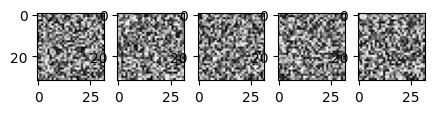

train[39]: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s, loss:-2.37268]


epoch[39] : -2.77007


train[39]: 100%|██████████| 469/469 [00:07<00:00, 65.94it/s]


epoch[39] : test loss - -2.37268


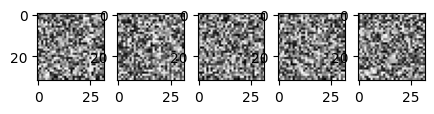

train[40]: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s, loss:-2.37268]


epoch[40] : -2.77007


train[40]: 100%|██████████| 469/469 [00:07<00:00, 65.84it/s]


epoch[40] : test loss - -2.37268


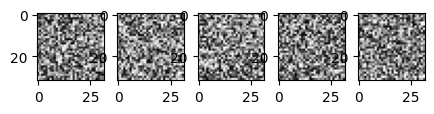

train[41]: 100%|██████████| 469/469 [00:48<00:00,  9.70it/s, loss:-2.37268]


epoch[41] : -2.77007


train[41]: 100%|██████████| 469/469 [00:07<00:00, 65.80it/s]


epoch[41] : test loss - -2.37268


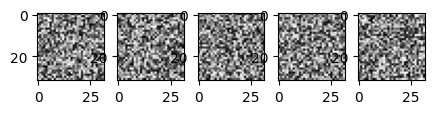

train[42]: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s, loss:-2.37268]


epoch[42] : -2.77007


train[42]: 100%|██████████| 469/469 [00:07<00:00, 66.47it/s]


epoch[42] : test loss - -2.37268


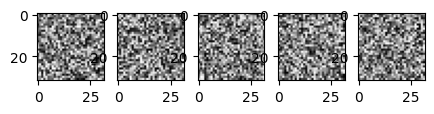

train[43]: 100%|██████████| 469/469 [00:48<00:00,  9.74it/s, loss:-2.37268]


epoch[43] : -2.77007


train[43]: 100%|██████████| 469/469 [00:07<00:00, 65.77it/s]


epoch[43] : test loss - -2.37268


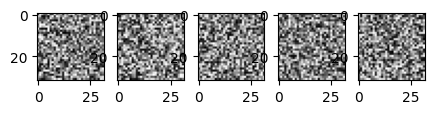

train[44]: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s, loss:-2.37268]


epoch[44] : -2.77007


train[44]: 100%|██████████| 469/469 [00:07<00:00, 66.78it/s]


epoch[44] : test loss - -2.37268


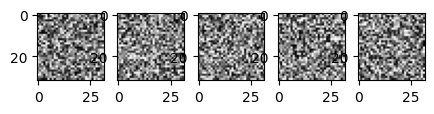

train[45]: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s, loss:-2.37268]


epoch[45] : -2.77007


train[45]: 100%|██████████| 469/469 [00:07<00:00, 66.47it/s]


epoch[45] : test loss - -2.37268


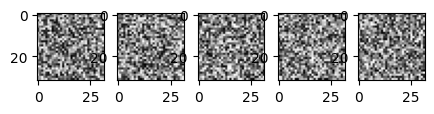

train[46]: 100%|██████████| 469/469 [00:48<00:00,  9.70it/s, loss:-2.37268]


epoch[46] : -2.77007


train[46]: 100%|██████████| 469/469 [00:07<00:00, 66.65it/s]


epoch[46] : test loss - -2.37268


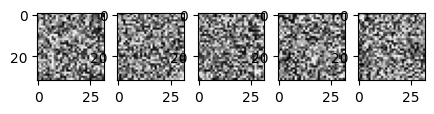

train[47]: 100%|██████████| 469/469 [00:49<00:00,  9.57it/s, loss:-2.37268]


epoch[47] : -2.77007


train[47]: 100%|██████████| 469/469 [00:07<00:00, 66.70it/s]


epoch[47] : test loss - -2.37268


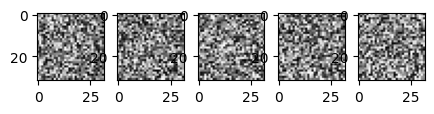

train[48]: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s, loss:-2.37268]


epoch[48] : -2.77007


train[48]: 100%|██████████| 469/469 [00:07<00:00, 66.76it/s]


epoch[48] : test loss - -2.37268


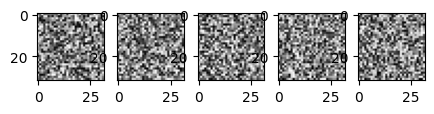

train[49]: 100%|██████████| 469/469 [00:49<00:00,  9.50it/s, loss:-2.37268]


epoch[49] : -2.77007


train[49]: 100%|██████████| 469/469 [00:07<00:00, 66.52it/s]


epoch[49] : test loss - -2.37268


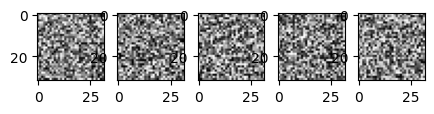

In [138]:
def train(model, buffer, optimizer, n_epoch, train_dl, test_dl, device):
    
    loss_history = []
    loss_test_history = []
    alpha = 0.1

    for epoch in range(n_epoch):
        model.train()
        loss_sum = 0
        n_total = 0 
        pbar = tqdm(train_dl, desc=f"train[{epoch}]")
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            # add random noise to data to prevent overfitting
            x += torch.randn_like(x) * 0.005 # 0.005 is stddev
            x = torch.clip(x, -1.0, 1.0)
            x = x.to(device)
            
            # get samples from buffer
            fake_imgs = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
            inp_imgs = torch.concat([x, fake_imgs], dim = 0)
            real_out, fake_out = torch.vsplit(model(inp_imgs), 2)

            # loss : -(\nabla model(x_train) - \nabla model(x_sample))
            contrastive_divergence_loss = -(
                torch.mean(real_out, dim=0) # x_train
                - torch.mean(fake_out, dim = 0) #x_sample
                )
            reg_loss = alpha * (torch.mean(real_out ** 2 + fake_out ** 2, dim=0))
            loss = contrastive_divergence_loss + reg_loss
            
            loss_sum += loss.item() * x.shape[0]
            n_total += x.shape[0] 
                    
            pbar.set_postfix_str(f"loss:{loss.item():.5f}")
            loss.backward()
            optimizer.step()
        
        epoch_loss = loss_sum / n_total
        print(f"epoch[{epoch}] : {epoch_loss:.5f}")
        loss_history.append(epoch_loss)

        model.eval()
        pbar = tqdm(train_dl, desc=f"train[{epoch}]")
        
        loss_sum_test = 0
        n_total_test = 0
        with torch.no_grad():
            for _, (x, _) in enumerate(pbar):
                fake_imgs = (torch.rand([x.shape[0], 1,32,32], device=device) * 2 - 1)
                x = x.to(device)
                inp_imgs = torch.concat([x, fake_imgs], dim = 0)
                real_out, fake_out = torch.vsplit(model(inp_imgs), 2)
                contrastive_divergence_loss = -(
                    torch.mean(real_out, dim=0) # x_train
                    - torch.mean(fake_out, dim = 0) #x_sample
                )

                loss_sum_test += loss.item() * x.shape[0]
                n_total_test += x.shape[0] 
        epoch_test_loss = loss_sum_test / n_total_test
        print(f"epoch[{epoch}] : test loss - {epoch_test_loss:.5f}")
        loss_test_history.append(epoch_test_loss)


        # test
        start_imgs = torch.rand([5, 1,32,32], device=device) * 2 - 1
        gen_imgs, _ = generate_samples(model=model, inp_imgs=start_imgs, steps=1000, step_size=10, noise=0.005)
        gen_imgs = gen_imgs.squeeze().detach().cpu().numpy()
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5,1))
        for i in range(5):
            axs[i].imshow(gen_imgs[i], cmap='gray')
        plt.show()
    
    return loss_history

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128

model = model.to(device)
buffer = Buffer(model, batch_size, device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
loss_history = train(model, buffer, optimizer, 50, dl, test_dl, device)